# Generalizing the Parametric Analysis Across Architectures
---
*An exploration of how the parametric analysis varies as the model architecture changes*

For more background, see the notebook [**Parametric Analysis**](../theory/parametric-analysis.ipynb).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np

from opda.nonparametric import EmpiricalDistribution
from opda.parametric import NoisyQuadraticDistribution
import opda.random

# constants

modality_to_experiments = {
    "vision": {
        "alexnet_tuning": {
            "family": "alexnet",
            "model": "AlexNet",
            "dataset": "ImageNet",
            "metric": "accuracy",
        },
        "resnet18_tuning": {
            "family": "resnet",
            "model": "ResNet18",
            "dataset": "ImageNet",
            "metric": "accuracy",
        },
        "convnext-tiny_tuning": {
            "family": "convnext",
            "model": "ConvNext Tiny",
            "dataset": "ImageNet",
            "metric": "accuracy",
        },
    },
    "language": {
        "deberta-base_tuning": {
            "family": "deberta",
            "model": "DeBERTa",
            "dataset": "MultiNLI-m",
            "metric": "accuracy",
        },
        "deberta-v3-base_tuning": {
            "family": "deberta",
            "model": "DeBERTaV3",
            "dataset": "MultiNLI-m",
            "metric": "accuracy",
        },
    },
}

modality_to_experiment_to_params = {
    # experiment                 : (convex, threshold),
    "vision": {
        "alexnet_tuning"         : ( False,     0.50),
        "resnet18_tuning"        : ( False,     0.67),
        "convnext-tiny_tuning"   : ( False,     0.60),
    },
    "language": {
        "deberta-base_tuning"    : ( False,     0.87),
        "deberta-v3-base_tuning" : ( False,     0.89),
    },
}

metric_to_bounds = {
    "accuracy": [0., 1.],
}

styles = {
    "empirical": {"linestyle": "--", "color": "#648FFF"},
    "theoretical": {"linestyle": "-", "color": "#FFB000"},
}

ns_grid = np.linspace(1., 128., num=1_024)

confidence_gof = 0.95


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## What Happens When You Change the Architecture?

In [**Validating the Parametric Analysis in Practice**](./validating-the-parametric-analysis-in-practice.ipynb), we found that the noisy quadratic distribution describes score distributions in practical deep learning scenarios. That case study examined different models on diverse tasks with distinct hyperparameter spaces. But, what if you hold the task and hyperparameter search space fixed? What happens if you only vary the model?

This scenario (comparing different models for the same task) makes up much of the research that goes on in deep learning. In such research, you don't know beforehand a reasonable range for the model's hyperparameters. Instead, you must fall back on your general knowledge about that kind of hyperparameter (e.g., the weight decay or learning rate). You have to use broad hyperparameter search spaces; therefore, it's important that the parametric analysis still works well with them. All the search spaces we've explored were designed to be broad in this way; by using them across models, we can put that to the test.

Another important question is: what properties of the score distribution transfer across models? Which aspects are properties of the search space itself, rather than details of the model we're tuning? We would not expect the best possible performance to stay constant across models, but perhaps the effective number of hyperparameters or the residual noise will?

To investigate these questions, we compare the score distributions from training different models with the same search space.

## Experimental Design

We explore two different scenarios, one on vision and the other on language data.

### Vision

For vision, we train three different models from scratch on ImageNet [(Russakovsky et al., 2014)](https://arxiv.org/abs/1409.0575). The first model, **AlexNet** [(Krizhevsky et al., 2012)](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), is widely considered to have launched the current deep learning revolution. As such, it is the oldest model we consider and lacks the subsequent advancements made in deep learning. The second model, **ResNet** [(He et al., 2015)](https://arxiv.org/abs/1512.03385), has become a strong baseline as the model is both powerful and well understood. ResNet has many, but not all, of the features found in modern convolutional networks. The third model, **ConvNext** [(Liu et al., 2022)](https://arxiv.org/abs/2201.03545) represents a major update to ResNet, incorporating additional more recent techniques. Together, these three models span a decade of advancements in deep learning.

All three models use the same training recipe and hyperparameter search space as ResNet in [**Validating the Parametric Analysis in Practice**](./validating-the-parametric-analysis-in-practice.ipynb), except we omit $\mathtt{use}\_\mathtt{blurpool}$ from the search space since it's incompatible with ConvNext's architecture:

$$
\begin{align*}
  \mathtt{epochs} &\sim \operatorname{DiscreteUniform}(20, 100) \\
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(\{128, 256, 512, 1024\}) \\
  \mathtt{lr} &\sim \operatorname{LogUniform}(5e{-}3, 5e1) \\
  \mathtt{lr}\_\mathtt{peak}\_\mathtt{epoch} &= \lfloor\mathtt{proportion} \times \mathtt{epochs}\rfloor,\; \mathtt{proportion} \sim \operatorname{Uniform}(0, 0.8) \\
  \mathtt{momentum} &\sim \operatorname{Uniform}(0.7, 1.0) \\
  \mathtt{weight}\_\mathtt{decay} &\sim \operatorname{LogUniform}(1e{-}6, 1e{-}3) \\
  \mathtt{label}\_\mathtt{smoothing} &\sim \operatorname{Uniform}(0, 0.5) \\
\end{align*}
$$

We ran 512 iterations of random search for AlexNet and ConvNext Tiny; for ResNet, we select the iterations of random search from [our previous experiment](./validating-the-parametric-analysis-in-practice.ipynb) where $\mathtt{use}\_\mathtt{blurpool} = 0$, which yields 495 iterations. Instead of *minimizing* top 1 *error rate* as in our previous experiment, here we *maximize* top 1 *accuracy* to provide an example of how to use the concave noisy quadratic distribution.

### Language

For language, we finetune two models on MultiNLI [(Adina et al., 2018)](https://arxiv.org/abs/1704.05426). The models are **DeBERTa** [(He et al., 2021)](https://arxiv.org/abs/2006.03654) and its successor **DeBERTaV3** [(He et al., 2023)](https://arxiv.org/abs/2111.09543). This scenario closely resembles what a researcher might expect when iterating on a model family, or comparing a model against a recent baseline.

The random search results for these models come from our previous investigation: [**Evaluating DeBERTaV3 with the Nonparametric Analysis**](./evaluating-debertav3-with-the-nonparametric-analysis.ipynb). They use the following hyperparameter search space:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of *the first epoch*.

We ran 1,024 iterations of random search for each model. As for the vision models, we maximize accuracy as the validation metric.

In [2]:
# Load the data.
modality_to_experiment_to_hparams_and_ys = {}
for modality, experiments in modality_to_experiments.items():
    modality_to_experiment_to_hparams_and_ys[modality] = {}
    for experiment in experiments:
        family = experiments[experiment]["family"]
        with open(f"../../data/{family}/{experiment}.results.jsonl") as f_in:
            hparams, ys = [], []
            for ln in f_in:
                ex = json.loads(ln)
                if modality == "vision":
                    hparams.append({
                        key: ex[key] if key != "use_blurpool" else ex.get(key, 0)
                        # Only ResNet18 has use_blurpool; use 0 (no blurpool) for other architectures.
                        for key in [
                            "epochs",
                            "batch_size",
                            "lr",
                            "lr_peak_epoch",
                            "momentum",
                            "weight_decay",
                            "label_smoothing",
                            "use_blurpool",
                        ]
                    })
                    ys.append(
                        # Use the best top_1 accuracy, even if the loss later became NaN.
                        max(epoch["top_1"] for epoch in ex["learning_curve"])
                        if len(ex["learning_curve"]) > 0 else
                        # Otherwise, use 0 if the loss became NaN in the first epoch.
                        0.,
                    )
                elif modality == "language":
                    hparams.append({
                        key: ex[key]
                        for key in [
                            "num_train_epochs",
                            "train_batch_size",
                            "learning_rate",
                            "warmup_steps",
                            "cls_drop_out",
                        ]
                    })
                    ys.append(max(
                        accuracy
                        for _, accuracy in ex["learning_curves"]["matched"]
                    ))
                else:
                    raise RuntimeError(f"Unrecognized experiment: {experiment}.")

            modality_to_experiment_to_hparams_and_ys[modality][experiment] = (
                hparams, np.array(ys),
            )

# Validate the data.
for experiment_to_hparams_and_ys in modality_to_experiment_to_hparams_and_ys.values():
    for experiment, (hparams, ys) in experiment_to_hparams_and_ys.items():
        total_samples = (
            512   if experiment in {"alexnet_tuning", "convnext-tiny_tuning"} else
            1_024
        )
        # Check the experiment has the expected number of samples.
        if len(hparams) != total_samples or len(ys) != total_samples:
            raise RuntimeError(
                f"{experiment} experiment has the wrong number of examples.",
            )

# Filter Resnet18 results for hyperparameter configurations with use_blurpool == 0.
for experiment, (hparams, ys) in modality_to_experiment_to_hparams_and_ys["vision"].items():
    hparams, ys = zip(*[
        (hparam, y)
        for hparam, y in zip(hparams, ys)
        if hparam["use_blurpool"] == 0
    ])
    modality_to_experiment_to_hparams_and_ys["vision"][experiment] = (
        list(hparams), np.array(ys),
    )

## Changing the Architecture in Vision

Let's compare score distributions across architectures when training from scratch on ImageNet.

AlexNet on ImageNet
Parameters        : a = 0.135, b = 0.582, c = 2.0, o = 6.2e-03, convex = False
Asymptotic Regime : threshold = 0.500, probability = 18.3%

ResNet18 on ImageNet
Parameters        : a = 0.601, b = 0.709, c = 2.0, o = 5.0e-03, convex = False
Asymptotic Regime : threshold = 0.670, probability = 36.1%

ConvNext Tiny on ImageNet
Parameters        : a = 0.041, b = 0.744, c = 2.0, o = 7.9e-03, convex = False
Asymptotic Regime : threshold = 0.600, probability = 20.4%



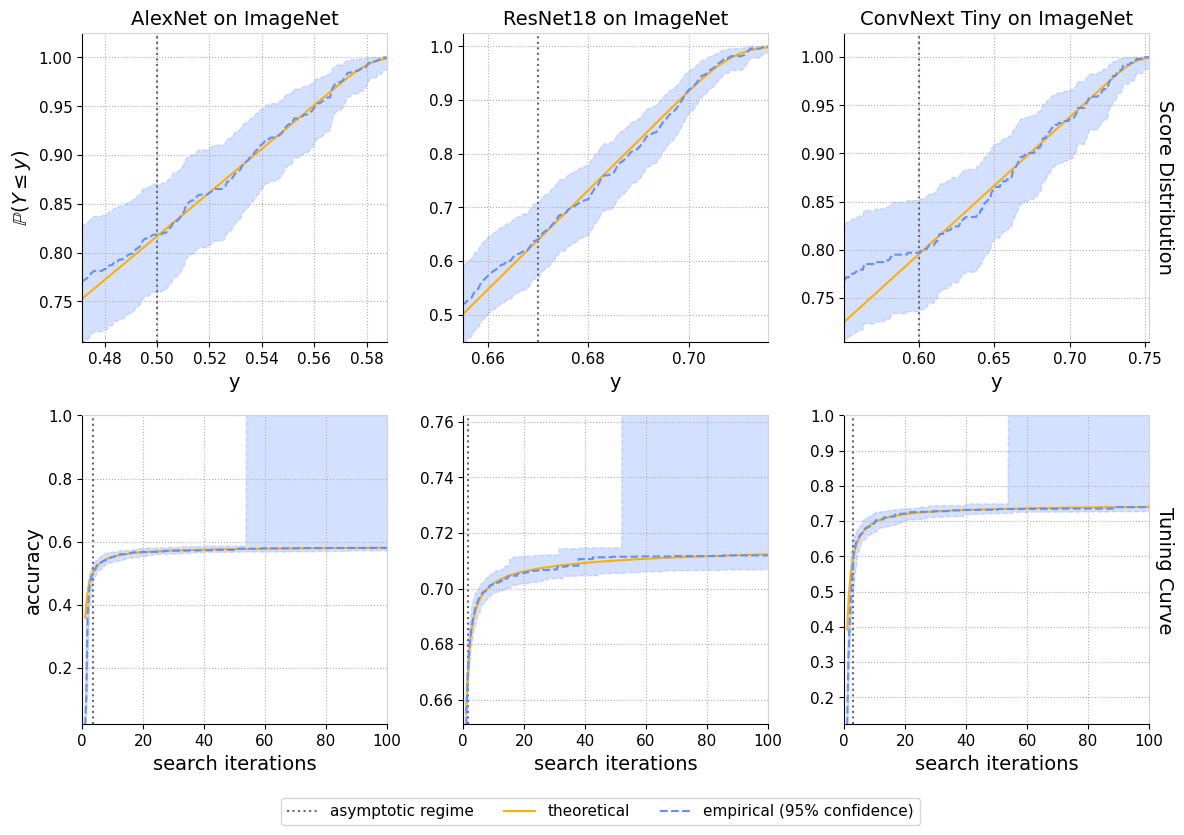

In [3]:
modality = "vision"

experiments = modality_to_experiments[modality]
experiment_to_params = modality_to_experiment_to_params[modality]
experiment_to_hparams_and_ys = modality_to_experiment_to_hparams_and_ys[modality]

n_models = len(experiments)

fig, axes = plt.subplots(nrows=2, ncols=n_models, figsize=(4 * n_models, 8))
for j, experiment in enumerate(experiments):
    hparams, ys = experiment_to_hparams_and_ys[experiment]
    (n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

    convex, threshold = experiment_to_params[experiment]

    y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
    ys_grid = np.linspace(
        y_max - 2 * (y_max - threshold), y_max,
        num=1_024,
    )

    # Compute the nonparametric ground truth.
    dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
        ys=ys, confidence=confidence_gof,
        a=y_min, b=y_max,
    )

    # Compute the parametric tail approximation.
    dist_tl = NoisyQuadraticDistribution.fit(
        ys,
        limits=(threshold, np.inf),
        constraints={
            "b": [y_min, y_max],
            "c": (1, n_hparams),
            "convex": convex,
        },
    )

    # Display the approximation's parameters.
    print(
        f"{experiments[experiment]['model']} on {experiments[experiment]['dataset']}\n"
        f"{'=' * (len(experiments[experiment]['model']) + 4 + len(experiments[experiment]['dataset']))}\n"
        f"Parameters        :"
        f" a = {dist_tl.a:.3f},"
        f" b = {dist_tl.b:.3f},"
        f" c = {dist_tl.c},"
        f" o = {dist_tl.o:.1e},"
        f" convex = {dist_tl.convex}"
        f"\n"
        f"Asymptotic Regime :"
        f" threshold = {threshold:.3f},"
        f" probability = {100 * (1 - dist_tl.cdf(threshold)):.1f}%"
        f"\n",
    )

    # Plot the asymptotic regime.
    #   CDF
    axes[0, j].axvline(
        threshold,
        linestyle=":",
        c="dimgray",
    )
    #   Tuning Curve
    axes[1, j].axvline(
        np.log(0.5) / np.log(dist_tl.cdf(threshold)),
        label="asymptotic regime",
        linestyle=":",
        c="dimgray",
    )

    # Plot the theoretical (parametric) approximation.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_tl.cdf(ys_grid),
        **styles["theoretical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_tl.quantile_tuning_curve(ns_grid),
        label="theoretical",
        **styles["theoretical"],
    )

    # Plot the empirical (nonparametric) ground truth.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_pt.cdf(ys_grid),
        **styles["empirical"],
    )
    axes[0, j].fill_between(
        ys_grid,
        dist_lo.cdf(ys_grid),
        dist_hi.cdf(ys_grid),
        alpha=0.275,
        **styles["empirical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_pt.quantile_tuning_curve(ns_grid),
        label=f"empirical ({100 * confidence_gof:.0f}% confidence)",
        **styles["empirical"],
    )
    axes[1, j].fill_between(
        ns_grid,
        dist_hi.quantile_tuning_curve(ns_grid),
        dist_lo.quantile_tuning_curve(ns_grid),
        alpha=0.275,
        **styles["empirical"],
    )

    # Format the plot.
    y_max_ = np.max(ys)
    y_median_ = np.median(ys)

    x_lim_cdf = (
        y_max_ - 4 / 3 * (y_max_ - threshold),
        y_max_ + 0.025 * (y_max_ - threshold),
    )
    y_lim_cdf = (dist_lo.cdf(x_lim_cdf[0]), 1.025)

    x_lim_tuning_curve = (0, 100)
    y_lim_tuning_curve = (
        y_median_,
        np.clip(y_median_ + 1.75 * (y_max_ - y_median_), 0., 1.),
    )

    axes[0, j].set_xlim(*x_lim_cdf)
    axes[0, j].set_ylim(*y_lim_cdf)
    axes[0, j].set_xlabel("y")
    axes[0, j].set_title(
        f"{experiments[experiment]['model']} on"
        f" {experiments[experiment]['dataset']}",
    )

    axes[1, j].set_xlim(*x_lim_tuning_curve)
    axes[1, j].set_ylim(*y_lim_tuning_curve)
    axes[1, j].set_xlabel("search iterations")

    for i in range(2):
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

axes[0, 0].set_ylabel(r"$\mathbb{P}\left(Y \leq y\right)$")
axes[1, 0].set_ylabel("accuracy")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Score Distribution", labelpad=18, rotation=270)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Tuning Curve", labelpad=18, rotation=270)

fig.tight_layout()

axes[1, 1].legend(
    loc="lower center",
    bbox_to_anchor=(0.45, -0.35) if modality == "vision" else (-0.15, -0.35),
    ncol=3,
)

plt.show()

For all three models, the asymptotic regime covers a large part of search space: 18.3% for AlexNet, 36.1% for ResNet18, and 20.4% for ConvNext Tiny. Consequently, the asymptotic regime determines the tuning curve after just 2-4 iterations of search. Thus, whether you're exploring less or more advanced architectures, there's good reason to believe that the noisy quadratic distribution will provide a powerful tool for understanding the hyperparameter loss surface.

Typically, we have a lot of prior knowledge and intuition from other experiments when we analyze a new research problem. Let's look at how the parameters of the noisy quadratic distribution change across the models.

As you might expect, the best possible performance ($\beta$) changes greatly across the models&mdash;after all, more advanced models are designed to attain better performance. The probability mass in the asymptotic regime (or equivalently, $\alpha$) also varies across the architectures, even though the probability mass remains reasonably large for all of them.

Unlike $\alpha$ and $\beta$, the residual noise, $\sigma$, remains comparable across models. Some of the variation could be due to estimation error. One could devise a hypothesis test for this question or run an experiment similar to our case study [**Analyzing Variation Due to Random Seeds**](./analyzing-variation-due-to-random-seeds.ipynb); however, we'll leave such investigation to future work.

Most interestingly, the effective number of hyperparameters, $\gamma$ appears fixed: for all models, the effective number of hyperparameters is 2. The effective number hyperparameters appears more to be a property of the task and the search space than the model itself. Should this be true, one could exploit this knowledge to estimate the noisy quadratic better, obtain tighter confidence intervals, and determine when adding a new hyperparameter fundamentally increases the complexity of tuning them.

## Changing the Architecture in Language

Let's see how our observations hold up when finetuning different pretrained models on MultiNLI.

DeBERTa on MultiNLI-m
Parameters        : a = 0.829, b = 0.887, c = 1.0, o = 1.9e-03, convex = False
Asymptotic Regime : threshold = 0.870, probability = 54.3%

DeBERTaV3 on MultiNLI-m
Parameters        : a = 0.859, b = 0.905, c = 1.0, o = 1.1e-03, convex = False
Asymptotic Regime : threshold = 0.890, probability = 57.5%



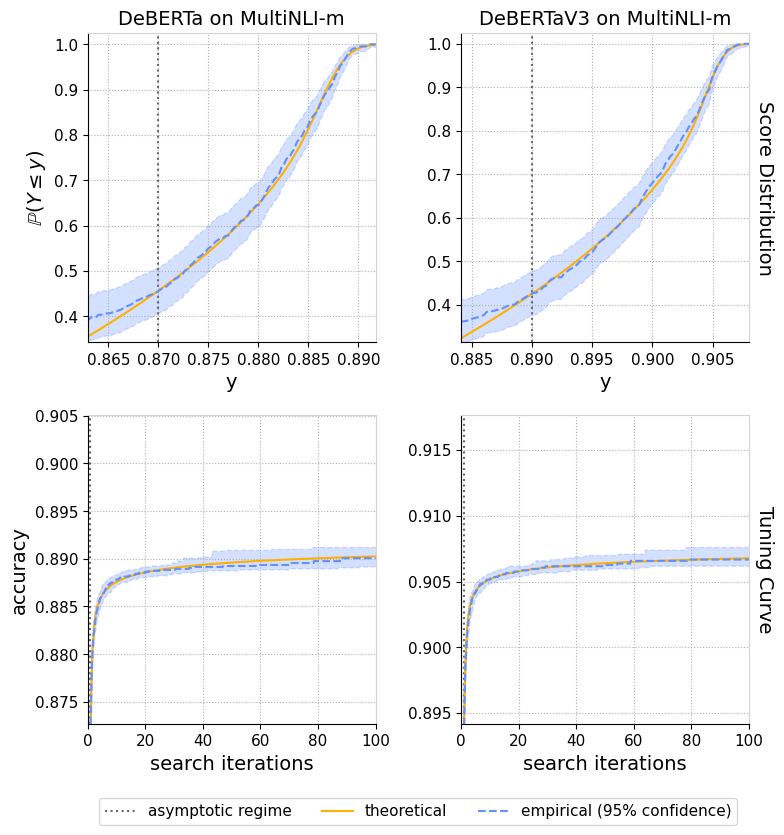

In [4]:
modality = "language"

experiments = modality_to_experiments[modality]
experiment_to_params = modality_to_experiment_to_params[modality]
experiment_to_hparams_and_ys = modality_to_experiment_to_hparams_and_ys[modality]

n_models = len(experiments)

fig, axes = plt.subplots(nrows=2, ncols=n_models, figsize=(4 * n_models, 8))
for j, experiment in enumerate(experiments):
    hparams, ys = experiment_to_hparams_and_ys[experiment]
    (n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

    convex, threshold = experiment_to_params[experiment]

    y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
    ys_grid = np.linspace(
        y_max - 2 * (y_max - threshold), y_max,
        num=1_024,
    )

    # Compute the nonparametric ground truth.
    dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
        ys=ys, confidence=confidence_gof,
        a=y_min, b=y_max,
    )

    # Compute the parametric tail approximation.
    dist_tl = NoisyQuadraticDistribution.fit(
        ys,
        limits=(threshold, np.inf),
        constraints={
            "b": [y_min, y_max],
            "c": (1, n_hparams),
            "convex": convex,
        },
    )

    # Display the approximation's parameters.
    print(
        f"{experiments[experiment]['model']} on {experiments[experiment]['dataset']}\n"
        f"{'=' * (len(experiments[experiment]['model']) + 4 + len(experiments[experiment]['dataset']))}\n"
        f"Parameters        :"
        f" a = {dist_tl.a:.3f},"
        f" b = {dist_tl.b:.3f},"
        f" c = {dist_tl.c},"
        f" o = {dist_tl.o:.1e},"
        f" convex = {dist_tl.convex}"
        f"\n"
        f"Asymptotic Regime :"
        f" threshold = {threshold:.3f},"
        f" probability = {100 * (1 - dist_tl.cdf(threshold)):.1f}%"
        f"\n",
    )

    # Plot the asymptotic regime.
    #   CDF
    axes[0, j].axvline(
        threshold,
        linestyle=":",
        c="dimgray",
    )
    #   Tuning Curve
    axes[1, j].axvline(
        np.log(0.5) / np.log(dist_tl.cdf(threshold)),
        label="asymptotic regime",
        linestyle=":",
        c="dimgray",
    )

    # Plot the theoretical (parametric) approximation.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_tl.cdf(ys_grid),
        **styles["theoretical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_tl.quantile_tuning_curve(ns_grid),
        label="theoretical",
        **styles["theoretical"],
    )

    # Plot the empirical (nonparametric) ground truth.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_pt.cdf(ys_grid),
        **styles["empirical"],
    )
    axes[0, j].fill_between(
        ys_grid,
        dist_lo.cdf(ys_grid),
        dist_hi.cdf(ys_grid),
        alpha=0.275,
        **styles["empirical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_pt.quantile_tuning_curve(ns_grid),
        label=f"empirical ({100 * confidence_gof:.0f}% confidence)",
        **styles["empirical"],
    )
    axes[1, j].fill_between(
        ns_grid,
        dist_hi.quantile_tuning_curve(ns_grid),
        dist_lo.quantile_tuning_curve(ns_grid),
        alpha=0.275,
        **styles["empirical"],
    )

    # Format the plot.
    y_max_ = np.max(ys)
    y_median_ = np.median(ys)

    x_lim_cdf = (
        y_max_ - 4 / 3 * (y_max_ - threshold),
        y_max_ + 0.025 * (y_max_ - threshold),
    )
    y_lim_cdf = (dist_lo.cdf(x_lim_cdf[0]), 1.025)

    x_lim_tuning_curve = (0, 100)
    y_lim_tuning_curve = (
        y_median_,
        np.clip(y_median_ + 1.75 * (y_max_ - y_median_), 0., 1.),
    )

    axes[0, j].set_xlim(*x_lim_cdf)
    axes[0, j].set_ylim(*y_lim_cdf)
    axes[0, j].set_xlabel("y")
    axes[0, j].set_title(
        f"{experiments[experiment]['model']} on"
        f" {experiments[experiment]['dataset']}",
    )

    axes[1, j].set_xlim(*x_lim_tuning_curve)
    axes[1, j].set_ylim(*y_lim_tuning_curve)
    axes[1, j].set_xlabel("search iterations")

    for i in range(2):
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

axes[0, 0].set_ylabel(r"$\mathbb{P}\left(Y \leq y\right)$")
axes[1, 0].set_ylabel("accuracy")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Score Distribution", labelpad=18, rotation=270)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Tuning Curve", labelpad=18, rotation=270)

fig.tight_layout()

axes[1, 1].legend(
    loc="lower center",
    bbox_to_anchor=(0.45, -0.35) if modality == "vision" else (-0.15, -0.35),
    ncol=3,
)

plt.show()

The language scenario echoes the observations from vision.

For both models, the asymptotic regime covers a significant fraction of the search space: 54.3% for DeBERTa and 57.5% for DeBERTaV3. In both cases, the asymptotic regime determines the tuning curve from the very first iteration.

The $\alpha$ and $\beta$ parameters vary, as DeBERTaV3 increases the best possible performance over DeBERTa. Similarly, $\sigma$ remains comparable, though not identical, across the two models.

Most importantly, DeBERTa and DeBERTaV3 share the same effective number of hyperparameters&mdash;just as in the vision case.

Thus, our conclusions appear to hold across modalities.

## Conclusion

Any tool for understanding hyperparameters should work well with broad search spaces applied to new problems.

In both vision and language, you can use the same search space across different architectures and find that the asymptotic regime describes a sizeable portion of the loss surface.

Within the asymptotic regime, we can use the noisy quadratic distribution to describe properties of the hyperparameter loss surface, in particular: the best possible performance, the residual noise, and the effective number of hyperparameters. Using this fact, we found that while the best possible performance changes across architectures (as one might hope!), the effective number of hyperparameters appears to remain the same. Thus, the effective number of hyperparameters is more a property of the search space than the model. This insight offers a new way to use our past experiences with a search space to estimate the noisy quadratic faster on new models. But, more than that, this insight suggests an important feature of the hyperparameter loss surface itself: it has an effective dimension which is robust across architectures.